## Importing libraries & datasets

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


True
12.1
NVIDIA GeForce GTX 1080 Ti


In [3]:
import zipfile

DATASET_PATH = "."

TRAIN_IMAGES_ZIP = os.path.join(DATASET_PATH, "ISIC_2020_Training_JPEG.zip")
TEST_IMAGES_ZIP = os.path.join(DATASET_PATH, "./2019_test/ISIC_2019_Test_Input.zip")
TRAIN_METADATA_PATH = os.path.join(DATASET_PATH, "ISIC_2020_Training_Metadata.csv")
TEST_METADATA_PATH = os.path.join(DATASET_PATH, "./2019_test/ISIC_2019_Test_Metadata.csv")

# Open zip files 
train_zip = zipfile.ZipFile(TRAIN_IMAGES_ZIP, 'r')
test_zip = zipfile.ZipFile(TEST_IMAGES_ZIP, 'r')

# Read metadata
train_metadata = pd.read_csv(TRAIN_METADATA_PATH)
test_metadata = pd.read_csv(TEST_METADATA_PATH)
print("Train Metadata:", train_metadata.shape)
print("Test Metadata:", test_metadata.shape)

Train Metadata: (33126, 8)
Test Metadata: (8238, 4)


## Data cleaning/verification & EDA
- Matching each image with its corresponding ID in metadata file. If not matched, exclude from dataset.

In [4]:
# Verify images & metadata matches
train_metadata['image_name_with_ext'] = train_metadata['image_name'] + '.jpg'
train_zip_contents = train_zip.namelist()
train_image_files = set([os.path.basename(f) for f in train_zip_contents if f.endswith('.jpg')])

test_metadata['image_name_with_ext'] = test_metadata['image'] + '.jpg'

filtered_metadata = train_metadata[train_metadata['image_name_with_ext'].isin(train_image_files)]
print("\nMetadata Size After Validation:", len(filtered_metadata))


Metadata Size After Validation: 33126


In [5]:
filtered_metadata.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'image_name_with_ext'],
      dtype='object')

In [6]:
# Multi-class 
class_counts = filtered_metadata['diagnosis'].value_counts()
class_counts

diagnosis
unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: count, dtype: int64

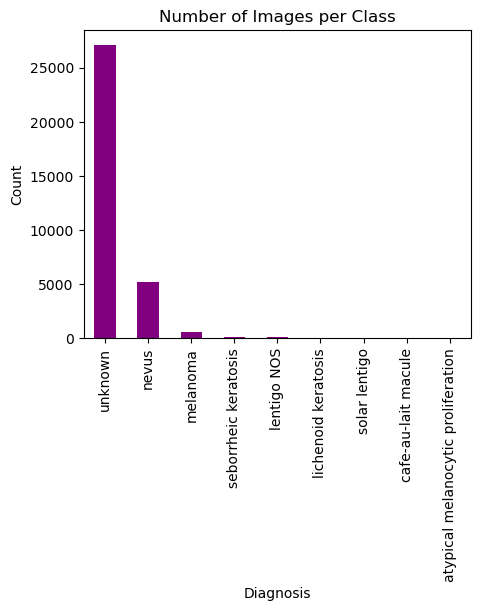

In [7]:
plt.figure(figsize=(5, 4))
class_counts.plot(kind='bar', color=['purple'])
plt.title('Number of Images per Class')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

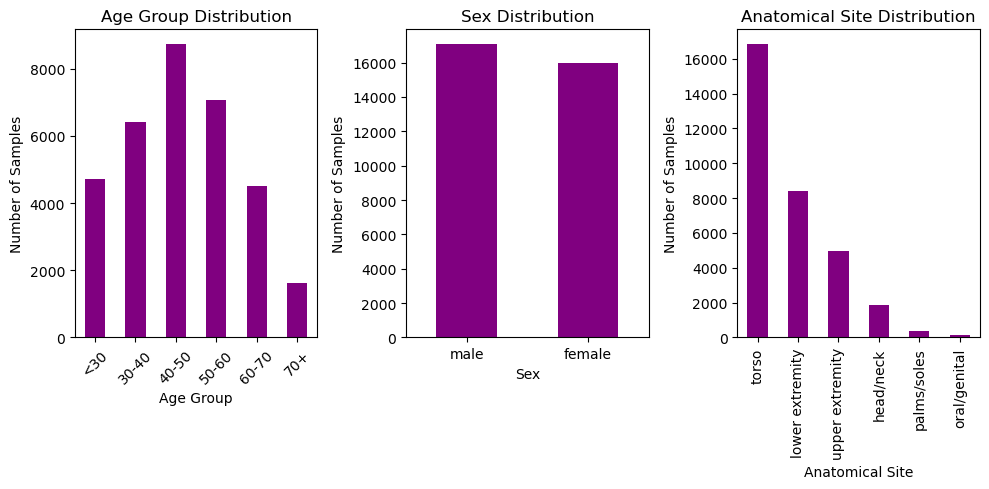

In [8]:
# General Data distribution
filtered_metadata['age_group'] = pd.cut(filtered_metadata['age_approx'],bins=[0, 30, 40, 50, 60, 70, 100],
                                        labels=['<30', '30-40', '40-50', '50-60', '60-70', '70+'])
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Age group distribution
filtered_metadata['age_group'].value_counts().sort_index().plot(kind='bar', color='purple', ax=axes[0])
axes[0].set_title('Age Group Distribution')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Sex distribution
filtered_metadata['sex'].value_counts().plot(kind='bar', color='purple', ax=axes[1])
axes[1].set_title('Sex Distribution')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=0)

# Anatomical site distribution
filtered_metadata['anatom_site_general_challenge'].value_counts().plot(kind='bar', color='purple', ax=axes[2])
axes[2].set_title('Anatomical Site Distribution')
axes[2].set_xlabel('Anatomical Site')
axes[2].set_ylabel('Number of Samples')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


/tmp/ipykernel_637/1467006572.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  melanoma_by_age = filtered_metadata.groupby('age_group')['benign_malignant'].apply(lambda x: (x == 'malignant').sum() / len(x) * 100)


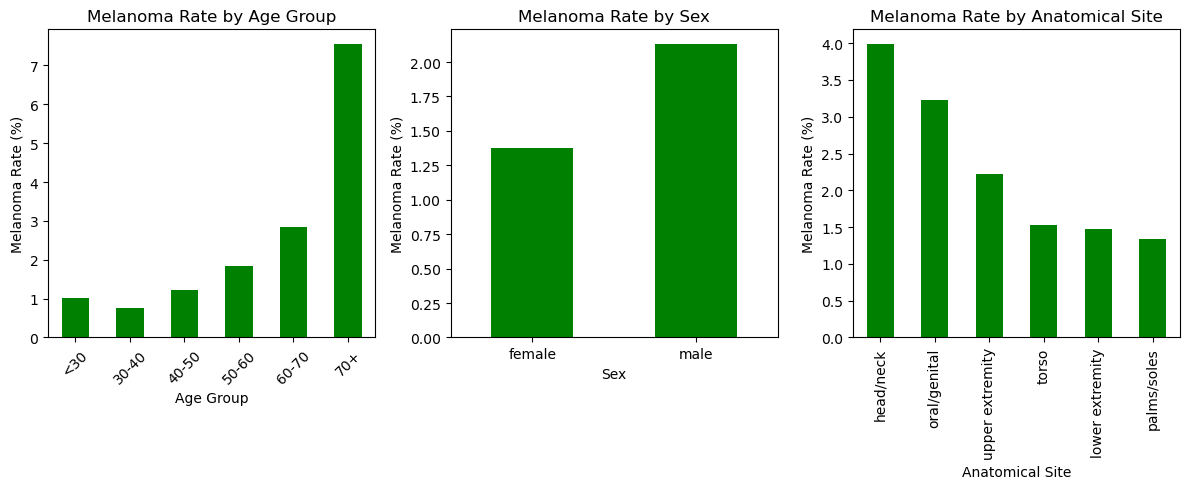

In [9]:
# Melanoma Rate by age groups, sex, and anatomical positions
filtered_metadata['age_group'] = pd.cut(filtered_metadata['age_approx'], 
                                          bins=[0, 30, 40, 50, 60, 70, 100],
                                          labels=['<30', '30-40', '40-50', '50-60', '60-70', '70+'])

melanoma_by_age = filtered_metadata.groupby('age_group')['benign_malignant'].apply(lambda x: (x == 'malignant').sum() / len(x) * 100)
melanoma_by_sex = filtered_metadata.groupby('sex')['benign_malignant'].apply(lambda x: (x == 'malignant').sum() / len(x) * 100)
melanoma_by_site = filtered_metadata.groupby('anatom_site_general_challenge')['benign_malignant'].apply(
    lambda x: (x == 'malignant').sum() / len(x) * 100).sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Age Group
melanoma_by_age.plot(kind='bar', color='green', ax=axes[0])
axes[0].set_title('Melanoma Rate by Age Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Melanoma Rate (%)')
axes[0].tick_params(axis='x', rotation=45)

# Sex
melanoma_by_sex.plot(kind='bar', color=['green'], ax=axes[1])
axes[1].set_title('Melanoma Rate by Sex')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Melanoma Rate (%)')
axes[1].tick_params(axis='x', rotation=0)

# Anatomical Site
melanoma_by_site.plot(kind='bar', color='green', ax=axes[2])
axes[2].set_title('Melanoma Rate by Anatomical Site')
axes[2].set_xlabel('Anatomical Site')
axes[2].set_ylabel('Melanoma Rate (%)')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Association of melanoma rate and pateints demographic
The chi-square analyses indicate statistically significant associations between both sex and malignancy (χ² = 26.65, p < 0.001) and anatomical site and malignancy (χ² = 70.75, p < 0.001). These results suggest that malignancy status is not independent of either patient sex or lesion anatomical location.

In [10]:
# CHI-SQUARE test: Sex vs Malignancy
contingency_sex = pd.crosstab(filtered_metadata['sex'], filtered_metadata['benign_malignant'])
chi2, p_value, dof, expected = chi2_contingency(contingency_sex)
print(f"\nChi-square test (Sex vs Malignancy):")
print(f"Chi2 statistic: {chi2:.4f}, p-value: {p_value:.4f}")

# Anatomical Site vs Malignancy
contingency_site = pd.crosstab(filtered_metadata['anatom_site_general_challenge'], filtered_metadata['benign_malignant'])
chi2, p_value, dof, expected = chi2_contingency(contingency_site)
print(f"\nChi-square test (Anatomical Site vs Malignancy):")
print(f"Chi2 statistic: {chi2:.4f}, p-value: {p_value:.4f}")


Chi-square test (Sex vs Malignancy):
Chi2 statistic: 26.6534, p-value: 0.0000

Chi-square test (Anatomical Site vs Malignancy):
Chi2 statistic: 70.7495, p-value: 0.0000


In [11]:
diagnosis_count = filtered_metadata['benign_malignant'].value_counts()
diagnosis_count

benign_malignant
benign       32542
malignant      584
Name: count, dtype: int64

# A Peak into Dermoscopic Images


Visualizing training samples...


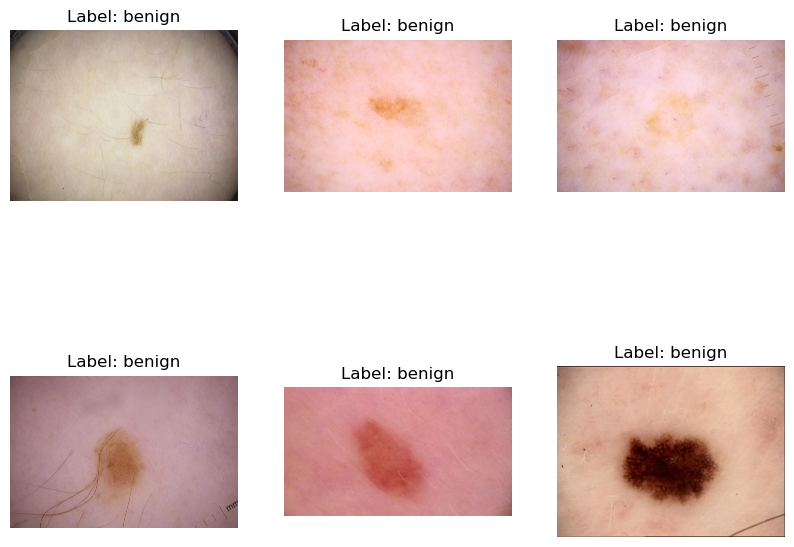

In [10]:
def visualize_samples(zip_file, folder_name, metadata, num_samples=6):
    if metadata.empty:
        print("\nNo valid samples to visualize.")
        return
    
    sample_images = metadata.sample(num_samples)
    plt.figure(figsize=(10, 8))
    
    for idx, (_, row) in enumerate(sample_images.iterrows()):
        img_path = f"{folder_name}/{row['image_name_with_ext']}"
        
        with zip_file.open(img_path) as file:
            image = Image.open(BytesIO(file.read())).convert('RGB')
        
        plt.subplot(2, 3, idx + 1)
        plt.imshow(image)
        plt.title(f"Label: {row['benign_malignant']}")
        plt.axis("off")
    
    plt.show()

print("\nVisualizing training samples...")
visualize_samples(train_zip, 'train', filtered_metadata)

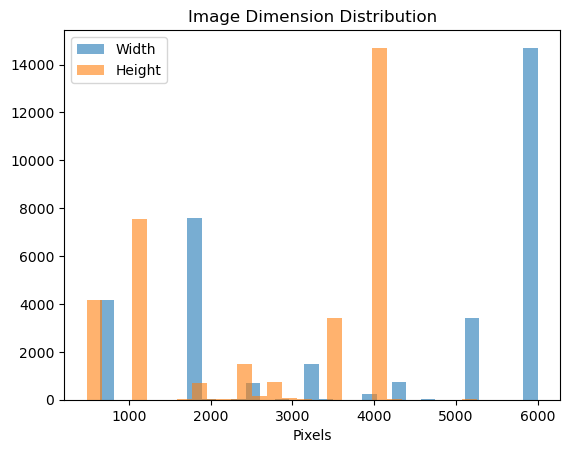

In [14]:
# Image dimension distribution
sizes = filtered_metadata['image_name_with_ext'].apply(
    lambda x: Image.open(BytesIO(train_zip.read(f"train/{x}"))).size)

widths, heights = zip(*sizes)
plt.hist(widths, bins=30, alpha=0.6, label='Width')
plt.hist(heights, bins=30, alpha=0.6, label='Height')
plt.xlabel('Pixels')
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()

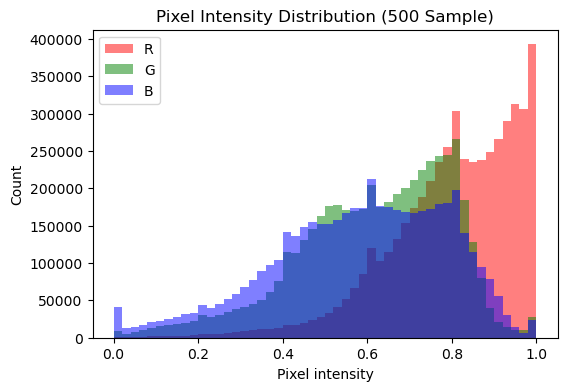

In [7]:
# Pixel Intensity Distribution in RGB
means = []
for x in filtered_metadata['image_name_with_ext'].sample(500, random_state=42):
    with train_zip.open(f"train/{x}") as file:
        img = Image.open(BytesIO(file.read())).convert('RGB')
        img = np.array(img).astype(np.float32) / 255.0
        flat_img = img.reshape(-1, 3)
        sample_indices = np.random.choice(len(flat_img), size=min(10000, len(flat_img)), replace=False)
        means.append(flat_img[sample_indices])

pixels = np.vstack(means)

plt.figure(figsize=(6,4))
for i, (c, color) in enumerate(zip(['R', 'G', 'B'], ['red', 'green', 'blue'])):
    plt.hist(pixels[:, i], bins=50, alpha=0.5, label=c, color=color)
plt.legend()
plt.title("Pixel Intensity Distribution (500 Sample)")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")
plt.show()

# Feature Engineer # 1

## Our Choice of CNN (ResNet50) – Preprocessing Requirements

- The ResNet50 architecture requires:
  - Uniform image dimensions  
  - Pixel intensity normalization  

**Image Resizing**
- Resize images to 224 × 224  
- Use black padding to preserve aspect ratio  
- Avoid distortion and maintain lesion integrity  

**Pixel Normalization**
- Apply ImageNet RGB mean normalization  
  - Mean: [0.485, 0.456, 0.406]  
  - Std: [0.229, 0.224, 0.225]  
- Ensure compatibility with pretrained weights  

In [13]:
# Normalize image size
class ResizeWithPadding:
    def __init__(self, size=224):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        scale = self.size / max(w, h)
        nw, nh = int(w * scale), int(h * scale)
        img = F.resize(img, (nh, nw))

        pad_w = self.size - nw
        pad_h = self.size - nh

        padding = (
            pad_w // 2, pad_h // 2,
            pad_w - pad_w // 2, pad_h - pad_h // 2)
        return F.pad(img, padding, fill=0)

data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    ResizeWithPadding(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  # ImageNet normalization


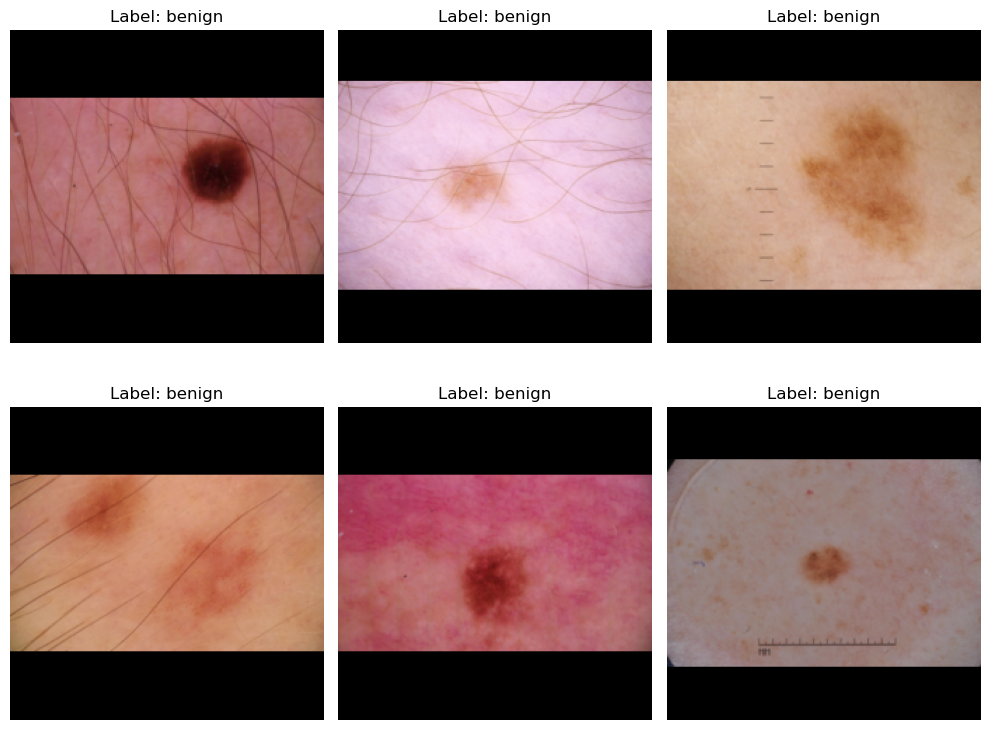

In [17]:
# Show samples after padding
sample_rows = filtered_metadata.sample(6, random_state=42)
plt.figure(figsize=(10, 8))
for idx, (_, row) in enumerate(sample_rows.iterrows()):
    with train_zip.open(f"train/{row['image_name_with_ext']}") as file:
        image = Image.open(BytesIO(file.read())).convert('RGB')
        image = np.array(image)  
    
    img_t = data_transforms(image)
    
    # Undo normalization for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    
    img_disp = img_t * std + mean          # un-normalize
    img_disp = img_disp.permute(1, 2, 0)   # CHW → HWC
    img_disp = torch.clamp(img_disp, 0, 1) # ensure in [0,1]
    
    # Plot
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img_disp.numpy())
    plt.title(f"Label: {row['benign_malignant']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preparing Data for Modeling

- Implemented a custom **PyTorch Dataset** class  
- Loads skin lesion images directly from a ZIP file  
- Applies optional transformations (if provided)  
- Returns:
  - Processed image  
  - Binary label (benign = 0, malignant = 1)  

**Purpose**
- Enable efficient data loading  
- Integrate seamlessly with PyTorch DataLoader  
- Prepare images and labels for model training  

In [11]:
from torch.utils.data import Dataset

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, zip_path, folder_name, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.zip_path = zip_path  
        self.folder_name = folder_name
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = f"{self.folder_name}/{row['image_name_with_ext']}"
        
        with zipfile.ZipFile(self.zip_path, 'r') as zip_file:
            with zip_file.open(img_path) as file:
                image = Image.open(BytesIO(file.read())).convert('RGB')
                image = np.array(image)
        
        if self.transform:
            image = self.transform(image)
        
        label = 1 if row['benign_malignant'] == 'malignant' else 0
        return image, label


In [12]:
# Split Train & Validation - 80/20 ratio @ seed 42 for reproducibility
if not filtered_metadata.empty:
    train_df, val_df = train_test_split(
        filtered_metadata, test_size=0.2, stratify=filtered_metadata['benign_malignant'], random_state=42)

    print("\nTraining Set Size:", len(train_df))
    print("Validation Set Size:", len(val_df))



Training Set Size: 26500
Validation Set Size: 6626


# Feature Engineering #2

**Training Pipeline**
- Apply resizing with padding (from Feature Engineering #1)  
- Perform data augmentation:
  - Random horizontal/vertical flips  
  - Random rotation  
  - Color jitter (brightness, contrast, etc.)  
- Convert images to tensors  
- Apply ImageNet normalization  
  - Mean: [0.485, 0.456, 0.406]  
  - Std: [0.229, 0.224, 0.225]  

**Purpose of Augmentation**
- Artificially increase data diversity & improve model generalization  
- Learn robust, invariant features to:
  - Rotation  
  - Flipping  
  - Lighting variations  
- Reduce overfitting  

**Validation & Test Pipeline**
- Apply resizing and normalization only  
- Do NOT apply augmentation  
- Ensure stable and unbiased model evaluation  

In [26]:
# Training transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    ResizeWithPadding(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation/Test transforms (NO augmentation)
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    ResizeWithPadding(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    ResizeWithPadding(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


## Handling Class Imbalance

- Dataset is highly imbalanced:
  - ~2% malignant (positive class)  
  - ~98% benign (negative class)  

**Strategy: WeightedRandomSampler (PyTorch)**

- Convert labels to binary:
  - Malignant = 1  
  - Benign = 0  
- Count number of samples per class  
- Compute class weights using inverse frequency:
  - Weight = 1 / (class count)  
- Assign higher weights to the minority (malignant) class  

**Sampling Process**
- Sample training examples **with replacement**  
- Minority-class images are selected more frequently  
- Produces a more balanced batch distribution during training  

**Benefit**
- Mitigates bias toward the majority class  
- Improves learning of rare malignant cases  
- Supports more stable and fair model training  

In [27]:
# WeightedRandomSampler 
from torch.utils.data import WeightedRandomSampler
train_labels = (train_df['benign_malignant'] == 'malignant').astype(int).values

class_counts = np.bincount(train_labels)
print(f"Class counts: {class_counts}") 

class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]

# Create sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_labels),
    replacement=True)

Class counts: [26033   467]


In [28]:
train_zip_path = 'ISIC_2020_Training_JPEG.zip'  

train_dataset = SkinLesionDataset(train_df, train_zip_path, 'train', transform=train_transforms)
val_dataset   = SkinLesionDataset(val_df, train_zip_path, 'train', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


# 2019 Test Data Loader

- The 2020 dataset does not provide publicly available test ground truth labels  
- Therefore, we used the 2019 test dataset as an alternative evaluation set  
  - Total images: 8,238  

**Rationale**
- A well-trained model should generalize to unseen data  
- The 2019 test set serves as an external evaluation benchmark  
- Helps assess real-world generalization performance  

In [47]:
# TEST DATA LOADER
class SkinLesionTestDataset(Dataset):
    def __init__(self, dataframe, zip_path, folder_name, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.zip_path = zip_path
        self.folder_name = folder_name
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = f"{self.folder_name}/{row['image_name_with_ext']}"
        
        with zipfile.ZipFile(self.zip_path, 'r') as zip_file:
            with zip_file.open(img_path) as file:
                image = Image.open(BytesIO(file.read())).convert('RGB')
                image = np.array(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image 
        
test_dataset = SkinLesionTestDataset(
    dataframe=test_metadata,
    zip_path='./2019_test/ISIC_2019_Test_Input.zip',
    folder_name='ISIC_2019_Test_Input', 
    transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# Baseline Modeling using Random Forest & Custom Feature Extraction

**Model**
- Implemented a classical machine learning baseline: Random Forest  

**Feature Extraction**
- Extracted handcrafted features from raw dermoscopic images  
- Total features: 49  

**Feature Categories**
- Color analysis features  
- Asymmetry quantification features  

**Clinical Motivation**
- Features grounded in established melanoma diagnostic criteria  
- Designed to capture clinically relevant patterns  
- Provide an interpretable baseline for comparison with CNN models  

## Color Features

- Extract **39 color features** from both RGB and LAB color spaces  
- **RGB Features**:
  - Compute per-channel statistics:
    - Mean, Standard deviation, Skewness, Kurtosis, Range, Percentiles, Entropy  
  - Calculated after per-pixel normalization  

- **LAB Features**:
  - Use **a** and **b** channels  
  - Capture perceptually uniform color information  

**Motivation**
- Dataset observations: e.g., red-channel dominance, high-intensity peaks  
- Enables effective differentiation between benign and malignant lesions  
- Provides a comprehensive color-based characterization of lesions  

In [ ]:
from skimage.color import rgb2lab

def extract_color_features(image):
    features = {}

    if isinstance(image, Image.Image):
        image = np.array(image).astype(np.float32)

    # Normalize RGB per pixel 
    rgb_sum = image.sum(axis=2, keepdims=True) + 1e-6
    rgb_norm = image / rgb_sum  # H x W x 3

    # RGB features
    for i, channel in enumerate(['r', 'g', 'b']):
        flat = rgb_norm[:, :, i].flatten()  # use all pixels
        features[f'mean_{channel}'] = np.mean(flat)
        features[f'std_{channel}'] = np.std(flat)
        features[f'range_{channel}'] = np.ptp(flat)
        
        # Skew and kurtosis
        mean = features[f'mean_{channel}']
        std = features[f'std_{channel}']
        if std > 0:
            features[f'skew_{channel}'] = np.mean(((flat - mean) / std) ** 3)
            features[f'kurt_{channel}'] = np.mean(((flat - mean) / std) ** 4) - 3
        else:
            features[f'skew_{channel}'] = 0
            features[f'kurt_{channel}'] = 0

        # Percentiles
        features[f'p25_{channel}'] = np.percentile(flat, 25)
        features[f'p50_{channel}'] = np.percentile(flat, 50)
        features[f'p75_{channel}'] = np.percentile(flat, 75)

        # Entropy
        hist, _ = np.histogram(flat, bins=32, range=(0, 1), density=True)
        hist = hist[hist > 0]
        features[f'entropy_{channel}'] = -np.sum(hist * np.log(hist))

    # Lab features
    lab_image = rgb2lab(image / 255.0)  # skimage expects 0-1
    for i, channel in enumerate(['L', 'a', 'b']):
        flat = lab_image[:, :, i].flatten()
        features[f'mean_{channel}'] = np.mean(flat)
        features[f'std_{channel}'] = np.std(flat)
        features[f'range_{channel}'] = np.ptp(flat)

    return features


## Asymmetry Features

- Extract multi-axis asymmetry features to quantify lesion symmetry  
- Address the **“A” (Asymmetry)** in the ABCDE melanoma rule  
- Motivation: malignant melanomas tend to be more asymmetric  

**Preprocessing**
- Convert images to grayscale  

**Asymmetry Measurements**
- Horizontal asymmetry (compare left vs. right halves)  
- Vertical asymmetry (compare top vs. bottom halves)  
- Diagonal asymmetry (compare opposite quadrants)  

**Statistical Comparisons**
- Mean difference  
- Standard deviation difference  
- Maximum difference  
- Mean absolute difference  

**Final Feature**
- Combine all measurements into an overall asymmetry score  
- Provides a comprehensive indicator of irregular growth patterns  
- Exploratory analysis shows benign lesions are generally more symmetric than malignant lesions  

In [24]:
from skimage.color import rgb2gray

def extract_asymmetry_features(image):
    features = {}

    if isinstance(image, Image.Image):
        image = np.array(image)

    # Convert to grayscale
    gray = rgb2gray(image) 

    h, w = gray.shape
    mid_h = h // 2
    mid_w = w // 2

    # Horizontal asymmetry
    top = gray[:mid_h, :]
    bottom = np.flipud(gray[h - mid_h:, :])
    h_diff = np.abs(top - bottom)
    features['h_asymmetry_mean'] = np.mean(h_diff)
    features['h_asymmetry_std'] = np.std(h_diff)
    features['h_asymmetry_max'] = np.max(h_diff)

    # Vertical asymmetry
    left = gray[:, :mid_w]
    right = np.fliplr(gray[:, w - mid_w:])
    v_diff = np.abs(left - right)
    features['v_asymmetry_mean'] = np.mean(v_diff)
    features['v_asymmetry_std'] = np.std(v_diff)
    features['v_asymmetry_max'] = np.max(v_diff)

    # Quadrant asymmetry
    q1 = gray[:mid_h, :mid_w]
    q2 = gray[:mid_h, w - mid_w:]
    q3 = gray[h - mid_h:, :mid_w]
    q4 = gray[h - mid_h:, w - mid_w:]

    d1_diff = np.abs(q1 - q4)
    d2_diff = np.abs(q2 - q3)

    features['d1_asymmetry_mean'] = np.mean(d1_diff)
    features['d2_asymmetry_mean'] = np.mean(d2_diff)
    features['overall_asymmetry'] = np.mean([features['h_asymmetry_mean'],features['v_asymmetry_mean'],features['d1_asymmetry_mean'],features['d2_asymmetry_mean']])

    return features


In [25]:
def extract_all_features(image):
    color_feats = extract_color_features(image)
    asymmetry_feats = extract_asymmetry_features(image)
    
    return {**color_feats, **asymmetry_feats}

In [26]:
def load_features_from_dataframe(df, zip_file, folder_name, sample_size=None):
    if sample_size:
        df_sample = (df.groupby('benign_malignant', group_keys=False).apply(lambda x: x.sample(n=min(sample_size, len(x)),replace=False,random_state=42))
                     .reset_index(drop=True))
    else:
        df_sample = df

    features_list, labels = [], []

    with zipfile.ZipFile(zip_file, 'r') as zf:
        for row in tqdm(df_sample.itertuples(index=False),
                        total=len(df_sample),
                        desc="Extracting features"):
            img_path = f"{folder_name}/{row.image_name_with_ext}"
            try:
                with zf.open(img_path) as file:
                    image = Image.open(file).convert('RGB')
                    feats = extract_all_features(image)
                    features_list.append(feats)
                    labels.append(1 if row.benign_malignant == 'malignant' else 0)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return pd.DataFrame(features_list), np.array(labels)


In [8]:
from tqdm import tqdm
features_df, labels = load_features_from_dataframe(train_metadata, 'ISIC_2020_Training_JPEG.zip', 'train', sample_size=1000)

/tmp/ipykernel_304/840585484.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = (df.groupby('benign_malignant', group_keys=False).apply(lambda x: x.sample(n=min(sample_size, len(x)),replace=False,random_state=42))
Extracting features: 100%|██████████| 1584/1584 [2:23:35<00:00,  5.44s/it]  


# Feature Space Structure: PCA and Clustering

#### In this section, we explore the structure of the handcrafted feature space using unsupervised learning techniques. We apply PCA to understand feature redundancy and variance structure, followed by K-means clustering to identify potential lesion subtypes and examine differences in malignant prevalence across clusters.


In [28]:
from tqdm import tqdm
features_df, labels = load_features_from_dataframe(train_metadata, 'ISIC_2020_Training_JPEG.zip', 'train', sample_size=3000)

/tmp/ipykernel_494/840585484.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = (df.groupby('benign_malignant', group_keys=False).apply(lambda x: x.sample(n=min(sample_size, len(x)),replace=False,random_state=42))
Extracting features: 100%|██████████| 3584/3584 [4:38:55<00:00,  4.67s/it]  


In [1]:
import os

os.makedirs("artifacts", exist_ok=True)

In [29]:
features_df.to_parquet(
    "artifacts/features_sample3000.parquet",
    index=False
)

np.save(
    "artifacts/labels_sample3000.npy",
    labels
)

In [8]:
features_df = pd.read_parquet("artifacts/features_sample3000.parquet")
labels = np.load("artifacts/labels_sample3000.npy")

print(features_df.shape)
print(len(labels))

(3584, 42)
3584


In [9]:
X = features_df.copy()
y = labels.copy()

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


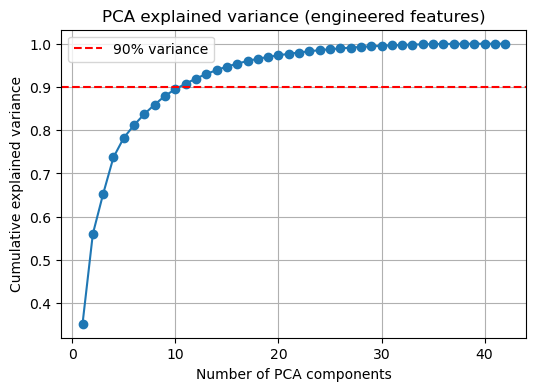

In [11]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(X_scaled)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.9, color='red', linestyle='--', label='90% variance')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance (engineered features)")
plt.legend()
plt.grid(True)
plt.show()


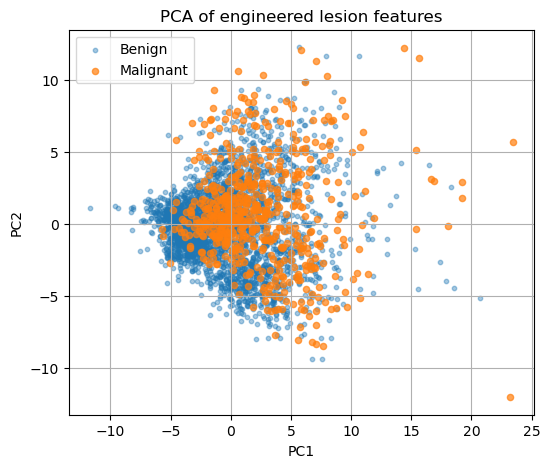

In [12]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca_2[y==0, 0], X_pca_2[y==0, 1],
            s=10, alpha=0.4, label="Benign")
plt.scatter(X_pca_2[y==1, 0], X_pca_2[y==1, 1],
            s=20, alpha=0.7, label="Malignant")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of engineered lesion features")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
pca_k = PCA(n_components=15, random_state=42)
X_pca_k = pca_k.fit_transform(X_scaled)

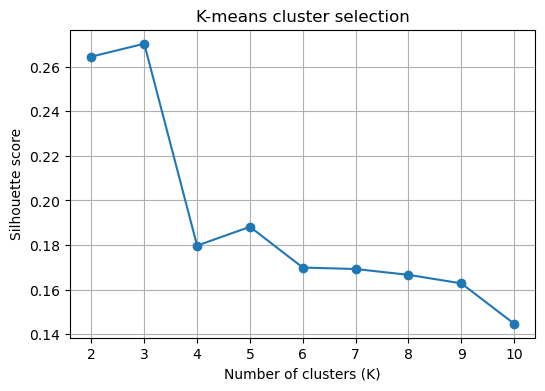

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []

K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels_k = km.fit_predict(X_pca_k)
    sil = silhouette_score(X_pca_k, labels_k)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("K-means cluster selection")
plt.grid(True)
plt.show()


In [15]:
best_k = K_range[np.argmax(sil_scores)]
print("Chosen K:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_pca_k)


Chosen K: 3


In [16]:
cluster_df = pd.DataFrame({
    "cluster": cluster_labels,
    "label": y
})

summary = (
    cluster_df
    .groupby("cluster")
    .agg(
        count=("label", "size"),
        malignant_rate=("label", "mean")
    )
    .sort_values("malignant_rate", ascending=False)
)

summary


,count,malignant_rate
cluster,,
1,724,0.298343
0,811,0.193588
2,2049,0.102977


In [13]:
np.mean(labels)

0.16294642857142858

## Interpretation of PCA and Clustering Results (Sample Size = 3000 per Class Cap)
To further investigate the structure of our handcrafted feature space, we applied PCA followed by K-means clustering to a stratified sample of the training data. Because the full dataset is highly imbalanced (≈1.8% malignant), we used our sampling strategy (sample_size=3000 per class cap), resulting in a working sample with an overall malignant rate of approximately 16.3%. This enriched sampling was used strictly for exploratory analysis and does not reflect real-world prevalence.

### Dimensionality Structure (PCA)
The cumulative explained variance plot shows that approximately 90% of the variance is captured by the first 10–12 principal components, despite starting with nearly 50 engineered features. This indicates substantial redundancy among the handcrafted color and asymmetry descriptors. Many of the RGB, LAB, and asymmetry statistics are highly correlated, suggesting that the intrinsic dimensionality of the engineered feature space is significantly lower than its raw dimensionality.
This finding validates the use of dimensionality reduction prior to clustering and suggests that downstream models may not require all handcrafted features to capture most of the variance structure.

### Low-Dimensional Separability
The 2D PCA visualization (PC1 vs. PC2) reveals substantial overlap between benign and malignant lesions. While malignant samples exhibit greater dispersion and extend further into extreme regions of feature space, there is no clear linear boundary separating the two classes in the first two principal components.
This suggests that although the engineered features encode meaningful structure, they do not provide simple low-dimensional linear separability between benign and malignant lesions. This partially motivates the use of more expressive models such as deep convolutional neural networks.

### Cluster Structure and Malignancy Enrichment
Using PCA-reduced features, K-means clustering achieved its highest silhouette score at K = 3, indicating the presence of three coarse structural groupings in feature space. Although silhouette scores were moderate (≈0.27 at best), suggesting that clusters are not sharply separated, meaningful differences in malignancy prevalence emerged across clusters:

Cluster 1: ~29.8% malignant
Cluster 0: ~19.4% malignant
Cluster 2: ~10.3% malignant
Overall sample rate: ~16.3%

Relative to the sample’s baseline malignancy rate, Cluster 1 is enriched by approximately 1.8×, while Cluster 2 is comparatively lower-risk (≈0.63× baseline rate).
Importantly, these clusters were discovered without using labels, indicating that unsupervised structure in the engineered feature space aligns with clinically relevant differences in malignancy prevalence. This suggests that the handcrafted features capture biologically meaningful variation, even though they do not produce clean low-dimensional class separation.

# Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features_df, labels, test_size=0.2, random_state=42, stratify=labels)

# Random Forest
#rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_b, y_train_b)
y_pred = rf.predict(X_test_b)

print("Accuracy:", accuracy_score(y_test_b, y_pred))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_b, y_pred))


Accuracy: 0.8172942817294282

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       600
           1       0.44      0.43      0.43       117

    accuracy                           0.82       717
   macro avg       0.66      0.66      0.66       717
weighted avg       0.82      0.82      0.82       717


Confusion Matrix:
 [[536  64]
 [ 67  50]]


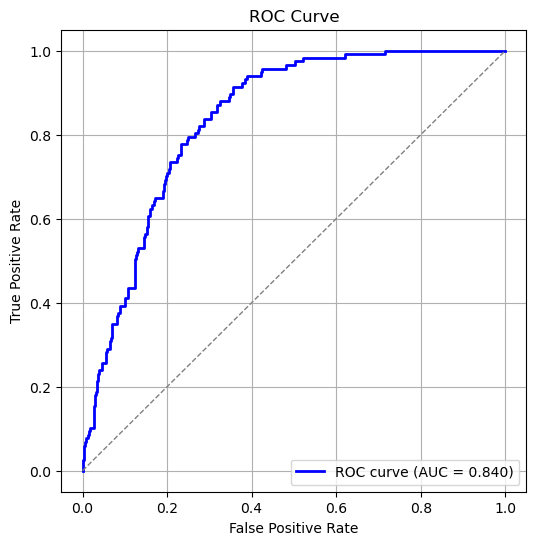

AUC: 0.840


In [18]:
# Predict probabilities 
y_prob = rf.predict_proba(X_test_b)[:, 1]  # probability of class 1 (malignant)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_b, y_prob)
roc_auc = auc(fpr, tpr)

# Display ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.3f}")


### Gini Feature Importance

In [19]:
importances = pd.Series(rf.feature_importances_, index=features_df.columns)
importances_sorted = importances.sort_values(ascending=False)

print("Top 15 features by Gini importance:")
display(importances_sorted.head(15).to_frame("gini_importance"))

Top 15 features by Gini importance:


,gini_importance
skew_b,0.061492
mean_L,0.058396
entropy_r,0.053088
skew_r,0.052024
std_g,0.049018
std_L,0.043442
std_a,0.042612
entropy_b,0.030189
kurt_r,0.028978
mean_a,0.027443


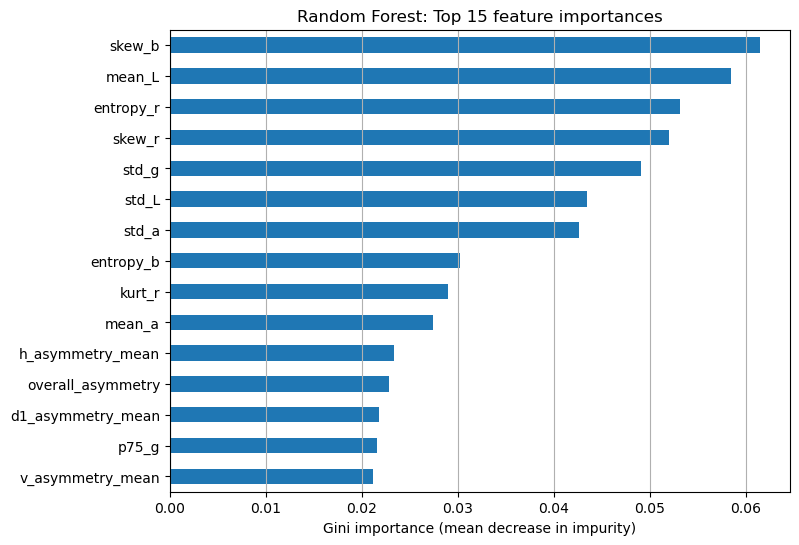

In [20]:
top_k = 15
plt.figure(figsize=(8, 6))
importances_sorted.head(top_k).sort_values().plot(kind="barh")
plt.xlabel("Gini importance (mean decrease in impurity)")
plt.title(f"Random Forest: Top {top_k} feature importances")
plt.grid(True, axis="x")
plt.show()

Top 15 features by permutation importance (AUC drop):


,perm_importance_mean
mean_L,0.018368
skew_b,0.009523
mean_a,0.006789
std_a,0.005887
std_g,0.005377
skew_r,0.005286
kurt_g,0.003769
range_L,0.003766
entropy_r,0.002806
skew_g,0.002801


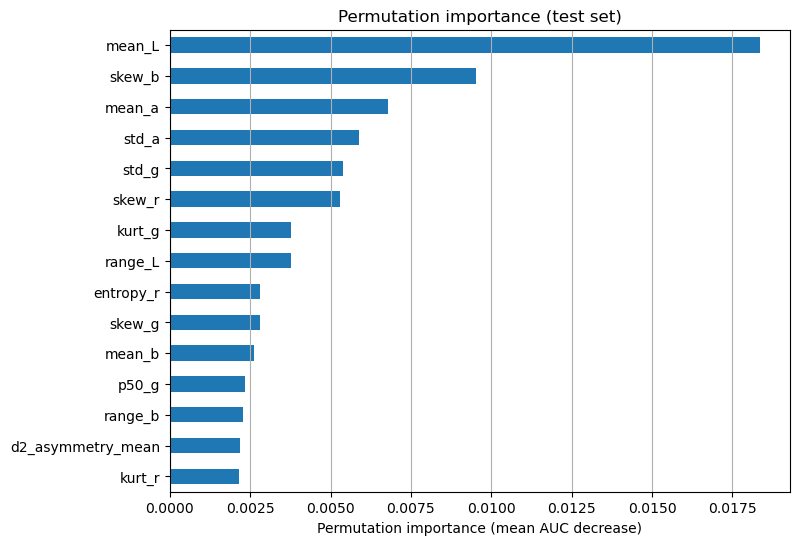

In [21]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test_b, y_test_b,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_imp = pd.Series(perm.importances_mean, index=features_df.columns).sort_values(ascending=False)

print("Top 15 features by permutation importance (AUC drop):")
display(perm_imp.head(15).to_frame("perm_importance_mean"))

plt.figure(figsize=(8, 6))
perm_imp.head(15).sort_values().plot(kind="barh")
plt.xlabel("Permutation importance (mean AUC decrease)")
plt.title("Permutation importance (test set)")
plt.grid(True, axis="x")
plt.show()

PR AUC: 0.450


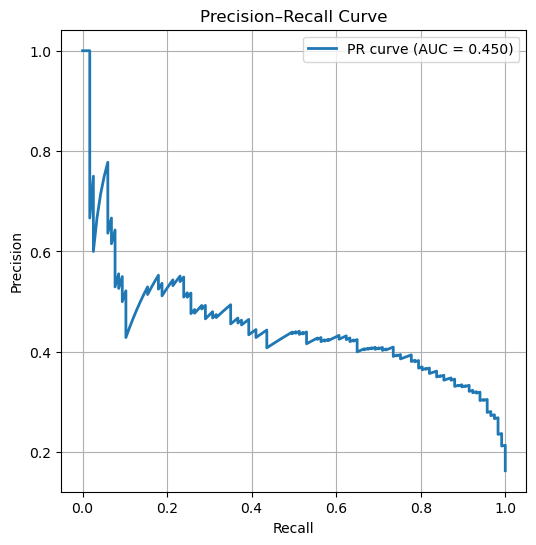

In [22]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test_b, y_prob)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.3f}")

plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


## Random Forest Feature Importance and Precision–Recall Analysis
To better understand how the Random Forest model makes predictions, we examined feature importance using two complementary approaches: mean decrease in impurity (Gini importance) and permutation importance measured by test-set AUC drop.

### Gini Importance (Mean Decrease in Impurity)
Gini importance measures how frequently a feature is used to split nodes across trees and how much those splits reduce class impurity. Features with higher values contribute more to reducing impurity during training.
The most influential features were predominantly color distribution statistics, including:
Skewness and kurtosis of RGB channels,
Entropy of color channels,
Standard deviation and range in LAB space,
Mean lightness (mean_L).
These descriptors quantify pigmentation irregularity and distribution shape within lesions. In contrast, geometric asymmetry features (horizontal, vertical, and diagonal asymmetry) appeared lower in the ranking.
This suggests that, within our handcrafted representation, irregular color variation plays a more dominant role than coarse structural asymmetry in distinguishing malignant from benign lesions. This finding aligns with clinical intuition: melanoma diagnosis frequently emphasizes irregular pigmentation patterns (the “C” in the ABCDE criteria), alongside asymmetry.
However, because many engineered features are correlated — as demonstrated earlier through PCA — Gini importances should be interpreted as a coarse ranking of feature groups rather than definitive causal attributions to individual variables. Correlated features tend to share importance, and continuous features may be favored by impurity-based metrics.

### Permutation Importance (Test-Set AUC Drop)
To obtain a more robust and less biased estimate of feature influence, we computed permutation importance using the decrease in ROC AUC when each feature is randomly shuffled in the test set.
Permutation importance confirmed the dominance of color-related descriptors. In particular:
mean_L (average lightness in LAB space) produced the largest AUC drop.
Higher-order distribution statistics such as skewness, entropy, and variance across RGB and LAB channels followed.
Asymmetry features contributed comparatively less to predictive performance.
Because permutation importance evaluates performance degradation on held-out data, it provides stronger evidence that luminance variation and color distribution irregularity are central predictive signals in this handcrafted feature space.
Importantly, these results are consistent with both the PCA analysis (which revealed strong redundancy among color statistics) and the unsupervised clustering results (which showed malignancy enrichment in certain regions of feature space).

### Precision–Recall Performance
Given that melanoma is a relatively rare condition in the full dataset, we evaluated model performance using the Precision–Recall (PR) curve in addition to ROC AUC.
The model achieved a PR AUC substantially above the baseline malignant prevalence of the sampled dataset. This indicates that the Random Forest meaningfully improves ranking of malignant lesions compared to random guessing.
However, at the default classification threshold (0.5), malignant recall was reduced, indicating that a significant fraction of malignant cases are not flagged as positive. This reflects a common tradeoff: while the model demonstrates reasonable ranking ability, the hard classification threshold may not be optimal when sensitivity to melanoma is prioritized.
In clinical screening contexts, higher recall (sensitivity) is often preferred, even at the cost of increased false positives. This highlights the importance of threshold tuning and cost-sensitive evaluation when transitioning from ranking metrics (AUC) to deployment-relevant decision rules.

# Modeling #1 - Resnet50

In [31]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torch.cuda.amp import GradScaler


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Focal Loss

- **Context:** Only 2% positive (malignant) samples in the dataset  
- **Combined Strategy:** WeightedRandomSampler + Focal Loss  

**WeightedRandomSampler**
- Ensures sufficient positive examples appear in each training batch  
- Helps balance the batch distribution  

**Focal Loss**
- Focuses learning on harder-to-classify positive samples  
- Down-weights easy negative examples  
- Improves model performance under extreme class imbalance  

**Benefit**
- Enables effective learning from rare malignant cases  
- Reduces bias toward the majority class  

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.99, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [7]:
def build_model():
    model = models.resnet50(weights="IMAGENET1K_V2")

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)

    return model.to(device)

## Focal Loss

- **Dataset Imbalance:** Only 2% positive (malignant) samples  
- **Approach:** Combine WeightedRandomSampler and Focal Loss  

**WeightedRandomSampler**
- Ensures enough positive samples in each training batch  
- Balances batch composition  

**Focal Loss**
- Emphasizes harder-to-classify positive examples  
- Down-weights easy negative samples  
- Helps the model handle extreme class imbalance  

**Overall Benefit**
- Supports effective learning from rare malignant cases  
- Reduces bias toward the majority class  

In [24]:
# Freezing 
def freeze_backbone(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

# Unfreeze
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [25]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(loader)


In [26]:
def validate(model, loader, criterion):
    model.eval()

    running_loss = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            probs = torch.sigmoid(outputs)

            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)

    return running_loss / len(loader), auc, all_labels, all_probs

## ResNet50 Stage 1

**Training Strategy**
- Train only the classifier on top of a **frozen ResNet-50 backbone**  
- Use **Focal Loss** with **alpha = 0.99** to handle class imbalance  

**Checkpointing**
- Configure automatic **resume from checkpoint** on crashes (3–4 hr timeout on Datahub)  
- Restore:
  - Model state  
  - Optimizer state  
  - Scaler state  
  - Best validation AUC  
  - Epoch number  

**Training Procedure**
- Train for **5 epochs**  
- Each epoch:
  - Forward and backward pass via `train_one_epoch`  
  - Validation using `validate` to compute loss and AUC  
  - Save best-performing model based on **validation AUC**  

**GPU Memory Management**
- Call `torch.cuda.empty_cache()` after each epoch  
- Prevents GPU memory accumulation during training  

In [33]:
model = build_model()
freeze_backbone(model)

criterion = FocalLoss(alpha=0.99, gamma=2)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

scaler = GradScaler("cuda")

best_auc = 0
epochs_stage1 = 5
epochs_stage2 = 5

start_epoch = 0

#  Resume if epoch
if os.path.exists("last_resnet50_stage1.pt"):
    checkpoint = torch.load("last_resnet50_stage1.pt")

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])

    best_auc = checkpoint["best_auc"]
    start_epoch = checkpoint["epoch"] + 1

    print(f"Resuming from epoch {start_epoch}")

# Stage 1
for epoch in range(start_epoch, epochs_stage1):

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_auc, labels, probs = validate(model, val_loader, criterion)

    print(f"Stage1 Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val AUC: {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
            "best_auc": best_auc}, "best_resnet50_stage1.pt")

    # Save LAST checkpoint 
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "best_auc": best_auc}, "last_resnet50_stage1.pt")

    torch.cuda.empty_cache()


Resuming from epoch 5


## Resnet Stage #2

We fine-tuned the ResNet-50 model after the initial classifier training. 
First, the unfreeze_model(model) function is called to make all layers trainable, allowing the backbone to adapt to skin lesion features. The optimizer is updated to train all model parameters with a lower learning rate (1e-5) compared to 1e-3 from the initial stage to prevent large updates that could destabilize pretrained weights. Similar to Stage 1, the code supports resuming training from a checkpoint (last_resnet50_stage2.pt).

In [45]:
# Fine tuning 
unfreeze_model(model)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

start_epoch = 0

if os.path.exists("last_resnet50_stage2.pt"):
    checkpoint = torch.load("last_resnet50_stage2.pt")

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])

    best_auc = checkpoint["best_auc"]
    start_epoch = checkpoint["epoch"] + 1

    print(f"Resuming Stage2 from epoch {start_epoch}")

# Stage 2 Training
for epoch in range(start_epoch, epochs_stage2):

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_auc, labels, probs = validate(model, val_loader, criterion)

    print(f"Stage2 Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val AUC: {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
            "best_auc": best_auc
        }, "best_resnet50_full.pt")

    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "best_auc": best_auc
    }, "last_resnet50_stage2.pt")

    torch.cuda.empty_cache()

# Save ensemble outputs 
# np.save("val_probs_resnet50.npy", probs)
# np.save("val_labels.npy", labels)


Resuming Stage2 from epoch 5


# Evaluation on Validation

## On the validation set of 6626 images, the model achieved a ROC AUC of 0.891, a PR AUC of 0.151, and a positive rate of 1.77%.

In [62]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_score, recall_score, f1_score, precision_recall_curve
)

y_true = np.load("val_labels.npy").astype(int)
y_prob = np.load("val_probs_resnet50.npy")

print("Loaded:", y_true.shape, y_prob.shape)
print("Val ROC AUC:", roc_auc_score(y_true, y_prob))
print("Val PR AUC: ", average_precision_score(y_true, y_prob))
print("Val positive rate:", y_true.mean())


Loaded: (6626, 1) (6626, 1)
Val ROC AUC: 0.8906878444441819
Val PR AUC:  0.1512750315954178
Val positive rate: 0.017657712043465137


## At the best F1 threshold of 0.69, the model correctly identified 33 true positives and 6388 true negatives, while producing 121 false positives and 84 false negatives, resulting in a precision of 0.214, recall of 0.282, and an F1 score of 0.244.

In [65]:
# Best threshold by F1
thresholds = np.linspace(0.0, 1.0, 101)
f1s = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
best_t = thresholds[int(np.argmax(f1s))]
print("Best threshold by F1:", best_t)

# Report metrics at that threshold
y_pred = (y_prob >= best_t).astype(int)
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall:   ", recall_score(y_true, y_pred, zero_division=0))
print("F1:       ", f1_score(y_true, y_pred, zero_division=0))


Best threshold by F1: 0.6900000000000001
Confusion matrix:
 [[6388  121]
 [  84   33]]
Precision: 0.21428571428571427
Recall:    0.28205128205128205
F1:        0.24354243542435425


In [68]:
rows = []
for t in np.linspace(0.0, 1.0, 21):
    y_pred = (y_prob >= t).astype(int)
    rows.append({
        "threshold": round(float(t), 2),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "positives_predicted": int(y_pred.sum())
    })
display(pd.DataFrame(rows))


,threshold,precision,recall,f1,positives_predicted
0,0.00,0.017658,1.000000,0.034703,6626
1,0.05,0.026322,0.991453,0.051282,4407
2,0.10,0.035614,0.974359,0.068716,3201
3,0.15,0.044201,0.931624,0.084398,2466
4,0.20,0.054620,0.914530,0.103083,1959
5,0.25,0.065217,0.871795,0.121356,1564
6,0.30,0.073634,0.794872,0.134783,1263
7,0.35,0.083089,0.726496,0.149123,1023
8,0.40,0.094176,0.649573,0.164502,807
9,0.45,0.105590,0.581197,0.178712,644


# Resnet50 on 2019 Test Set

In [5]:
def test_probs(model, test_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
    return np.concatenate(all_probs).flatten()

In [10]:
checkpoint = torch.load("best_resnet50_full.pt")
# model.load_state_dict(checkpoint["model_state_dict"])
# model = model.to(device)
# model.eval()

In [75]:
# test_probs_r = test_probs(model, test_loader, device)
# np.save("test_probs_resnet50.npy", test_probs_r)

In [11]:
test_labels = pd.read_csv("./2019_test/ISIC_2019_Test_GroundTruth.csv")
y_true = test_labels['MEL'].values  # 1 = melanoma, 0 = not
test_probs_r = np.load("test_probs_resnet50.npy").flatten()


## On the test set (n = 8238), ResNet50 chieved a ROC AUC of 0.706 and an overall accuracy of 75%; however, for Melanoma detection specifically, it obtained a precision of 0.32, recall (sensitivity) of 0.49, and an F1-score of 0.39, indicating moderate ranking ability but limited effectiveness in reliably identifying Melanoma cases, with nearly half of true positives missed and a substantial number of false positives.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Convert probs to binary predictions (threshold 0.3)
y_pred = (test_probs_r >= 0.69).astype(int)

print(f"AUC: {roc_auc_score(y_true, test_probs_r):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Melanoma', 'Melanoma']))

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"TP (Melanoma correctly detected):     {tp}")
print(f"TN (Non-Melanoma correctly rejected): {tn}")
print(f"FP (Non-Melanoma flagged as Melanoma):{fp}")
print(f"FN (Melanoma missed):                 {fn}")

print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity:          {tn/(tn+fp):.4f}")
print(f"Precision:            {tp/(tp+fp):.4f}")


AUC: 0.7056

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.89      0.80      0.84      6911
    Melanoma       0.32      0.49      0.39      1327

    accuracy                           0.75      8238
   macro avg       0.61      0.65      0.62      8238
weighted avg       0.80      0.75      0.77      8238

TP (Melanoma correctly detected):     652
TN (Non-Melanoma correctly rejected): 5533
FP (Non-Melanoma flagged as Melanoma):1378
FN (Melanoma missed):                 675

Sensitivity (Recall): 0.4913
Specificity:          0.8006
Precision:            0.3212


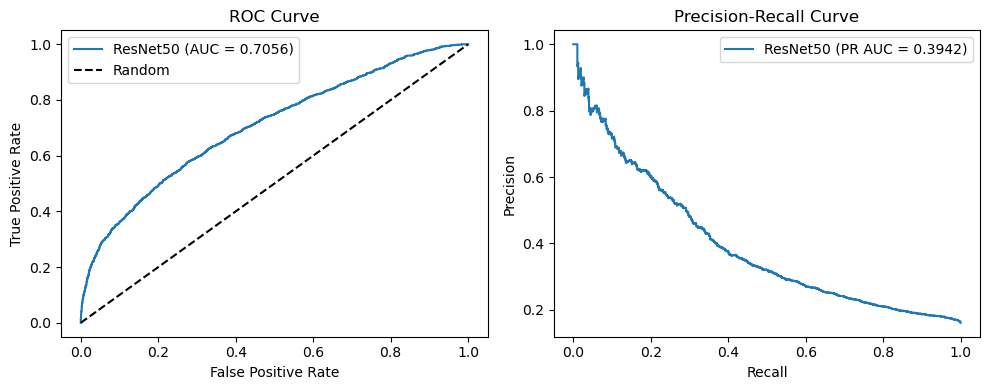

In [31]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# ROC
fpr, tpr, _ = roc_curve(y_true, test_probs_r)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_true, test_probs_r)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ROC
axes[0].plot(fpr, tpr, label=f'ResNet50 (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# PR
axes[1].plot(recall, precision, label=f'ResNet50 (PR AUC = {pr_auc:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

## Conclusion: ResNet50 alone provides moderate discrimination (ROC-AUC ~0.70) but struggles with precision at higher recall thresholds, which is expected given severe class imbalance. This motivates your ensemble approach, we expect EfficientNet and the ensemble to push both curves upward, particularly in the high-recall region of the PR curve.